In [4]:
import math
from decimal import Decimal
import numpy as np
import cv2
import glob
#from tracker import tracker
from moviepy.editor import VideoFileClip
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Function

In [5]:
dist_pickle = pickle.load( open( "camera_cal/calibration_ pickle.p", "rb" ) )
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

In [6]:
def distortion_correction(image_datum, mtx, dist):
    dst = cv2.undistort(image_datum, mtx, dist, None, mtx)
    
    return dst

## Enhance Contrast using histogram equalization
def enhanceContrastOfImage(img):
    #return cv2.equalizeHist(img)

    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_img[:,:,0] = cv2.equalizeHist(np.asarray(yuv_img[:,:,0], np.uint8))
    return cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

# Appies Colour threshold
def colour_threshold(img, hthresh=(80,102), lthresh=(230,255), sthresh=(200, 255), vthresh=(220, 255), bthresh=(155,200)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= hthresh[0]) & (h_channel <= hthresh[1])] = 1
    
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 1
    
    s_channel = hls[:,:,2]
    s_binary = np.ones_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 0

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    Lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    b_channel = Lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= bthresh[0]) & (b_channel <= bthresh[1])] = 1

    return h_binary, l_binary, s_binary, v_binary, b_binary

def grad_threshold(enhanced_img):
    # Apply Sobel x or y, then takes an absolute value and applies a threshold.
    # A function that takes an image, gradient orientation, and threshold min / max values.
    def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output


    # Applies Sobel x and y, then computes the magnitude of the gradient
    # and applies a threshold.
    # A function to return the magnitude of the gradient
    # for a given sobel kernel size and threshold values
    def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output


    # Applies Sobel x and y, then computes the direction of the gradient
    # and applies a threshold.
    # A function to threshold an image for a given range and Sobel kernel
    def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    abs_x = abs_sobel_thresh(enhanced_img, orient='x', thresh_min=25, thresh_max=100)
    abs_y = abs_sobel_thresh(enhanced_img, orient='y', thresh_min=50, thresh_max=150)
    mag_grad = mag_thresh(enhanced_img, sobel_kernel=9, mag_thresh=(50, 250))
    #dir_grad = dir_threshold(enhanced_img, sobel_kernel=15, thresh=(40*np.pi/180, 80*np.pi/180))
    dir_grad = dir_threshold(enhanced_img, sobel_kernel=15, thresh=(30*np.pi/180, 80*np.pi/180))
    
    grad_filter = np.zeros_like(enhanced_img[:,:,0])
    grad_filter[(abs_x == 1) | (abs_y == 1) | ((mag_grad == 1) ) & (dir_grad == 1)] = 1
    
    return grad_filter
    
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    # print("mask: ", mask.shape)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        # print("True")
    else:
        ignore_mask_color = 255
        # print("False")

    # Mask
    imshape = np.shape(img)

    bottom_mask = 490
    middle_mask = 80
    width_center = imshape[1]*0.5
    height_center = imshape[0]*0.6
    height_bottom = imshape[0]*0.07

    vertices_outer = np.array([(width_center-bottom_mask,imshape[0]-height_bottom),
                            (width_center-middle_mask, height_center),
                            (width_center+middle_mask, height_center),
                            (width_center+bottom_mask,imshape[0]-height_bottom)], dtype=np.int32)

    inner_bottom_mask = 230
    inner_middle_mask = 20
    inner_height_center = imshape[0]*0.7
    inner_height_bottom = imshape[0]*0.07

    vertices_inner = np.array([(width_center-inner_bottom_mask,imshape[0]-height_bottom),
                            (width_center-inner_middle_mask, inner_height_center),
                            (width_center+inner_middle_mask, inner_height_center),
                            (width_center+inner_bottom_mask,imshape[0]-height_bottom)], dtype=np.int32)

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices_outer], ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    cv2.fillPoly(masked_image, [vertices_inner], 0)
    
    return masked_image

def perspective_transform(image_data):
    img = np.copy(image_data)
    imshape = np.shape(img)
    img_size = (img.shape[1], img.shape[0])

    # work on defining perspective transformation area    
    src_bottom_mask = 490
    src_middle_mask = 120
    src_width_center = imshape[1]*0.5
    src_middle_height = imshape[0]*0.62
    src_bottom_height = imshape[0]*0.95
    
    src = np.array([(src_width_center-src_bottom_mask, src_bottom_height),
                    (src_width_center-src_middle_mask, src_middle_height),
                    (src_width_center+src_middle_mask, src_middle_height),
                    (src_width_center+src_bottom_mask, src_bottom_height)], dtype=np.int32)

    # work on defining transformation area
    dst_bottom_mask = 100
    dst_middle_mask = 200
    dst_width_center = imshape[1]*0.5
    dst_middle_height = imshape[0]*0
    dst_bottom_height = imshape[0]*0.95

    dst = np.array([ (dst_width_center-dst_bottom_mask, dst_bottom_height), 
                    (dst_width_center-dst_middle_mask, dst_middle_height),
                    (dst_width_center+dst_middle_mask, dst_middle_height),
                    (dst_width_center+dst_bottom_mask, dst_bottom_height)], dtype=np.int32)
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
    Minv = cv2.getPerspectiveTransform(dst.astype(np.float32),src.astype(np.float32))
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

def sliding_windows_and_poly_fit(transformed_image, num_windows=9, margin = 100):
    binary_warped = np.copy(transformed_image)
    
    # Assuming you have creaed a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = num_windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Create an image to draw on and an image to show the selection window
    poly_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    poly_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    poly_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin+40, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin-40, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin+40, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin-40, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(poly_img, 1, window_img, 0.8, 0)
    
    return out_img, left_fitx, right_fitx, ploty, result

In [9]:
def lane_finding_pipe_line(img):
    undistorted_img = distortion_correction(img, mtx, dist)
    
    enhanced_img = enhanceContrastOfImage(undistorted_img)
    
    h_binary, l_binary, s_binary, v_binary, b_binary = colour_threshold(enhanced_img, hthresh=(20,50), lthresh=(150,255), 
                                                                        sthresh=(10, 180), vthresh=(240, 255), bthresh=(90,115))
    grad_binary = grad_threshold(enhanced_img)
    
    '''
    hbsvl_thresh = np.zeros_like(h_binary)
    hbsvl_thresh[( ( (h_binary == 1) | (b_binary == 1) ) | ( (s_binary == 1) & (v_binary == 1) ) ) & (l_binary == 1)] = 1
    masked_img = region_of_interest(hbsvl_thresh)
    '''
    
    filtered_img = np.zeros_like(h_binary)
    filtered_img[( ( ( (h_binary == 1) | (b_binary == 1) ) | ( (s_binary == 1) & (v_binary == 1) ) ) & (l_binary == 1) ) | ( grad_binary == 1)] = 1
    masked_img = region_of_interest(filtered_img)
    
    transformed_img, M, Minv = perspective_transform(masked_img)    

    fit_img, left_fit_x, right_fit_x, fit_y, polygon_window = sliding_windows_and_poly_fit(transformed_img, num_windows=20, margin = 35)

    road_warped = cv2.warpPerspective(polygon_window, Minv, (polygon_window.shape[1], polygon_window.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted_img, 1, road_warped, 0.3, 0)

    #plt.imshow(result)
    return result

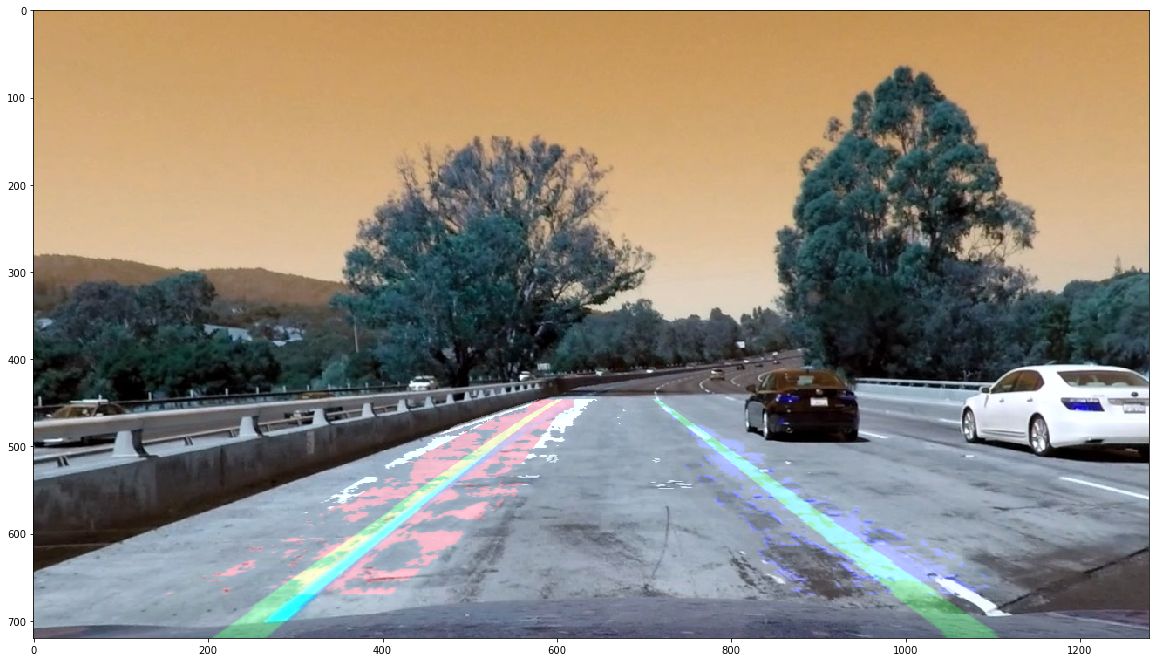

In [10]:
img = np.copy(cv2.imread('./test_images/test1.jpg'))

result = lane_finding_pipe_line(img)
plt.figure(figsize=(20, 20))
plt.imshow(result)

In [11]:
output_video = './output_tracked_v2.mp4'
input_video = './project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(lane_finding_pipe_line) # NOTE: this function expects colour images!!
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_tracked_v2.mp4
[MoviePy] Writing video ./output_tracked_v2.mp4


100%|█████████▉| 1260/1261 [04:19<00:00,  4.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_tracked_v2.mp4 

